In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('./data/HAM10000_Metadata')

(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [4]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,96,HAM_0001473,ISIC_0029022,bkl,histo,70.0,male,face,vidir_modern
1,5898,HAM_0001225,ISIC_0025977,nv,follow_up,25.0,female,trunk,vidir_molemax
2,2743,HAM_0004880,ISIC_0028583,bcc,histo,65.0,male,back,rosendahl
3,4346,HAM_0007554,ISIC_0028193,nv,follow_up,55.0,female,lower extremity,vidir_molemax
4,1904,HAM_0004844,ISIC_0033394,mel,histo,50.0,male,trunk,vidir_modern


In [5]:
df['localization'].unique()

array(['face', 'trunk', 'back', 'lower extremity', 'foot',
       'upper extremity', 'abdomen', 'unknown', 'scalp', 'hand', 'chest',
       'neck', 'ear', 'genital', 'acral'], dtype=object)

In [6]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0.5 if df.iloc[i]['sex'] == 'male' else -0.5
    age = df.iloc[i]['age'] / 80
    loc = df.iloc[i]['localization']
    
    feat = np.array([age, sex])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15) - 0.5))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15) - 0.5))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15) - 0.5))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15) - 0.5))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15) - 0.5))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15) - 0.5))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15) - 0.5))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15) - 0.5))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15) - 0.5))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15) - 0.5))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15) - 0.5))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15) - 0.5))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15) - 0.5))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15) - 0.5))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15) - 0.5))

    feature_vector.append(feat)
    
feat_X = np.array(feature_vector)

100%|██████████████████████████████████████████████████████████████████████████| 10015/10015 [00:08<00:00, 1228.78it/s]


In [7]:
# VGG-16
preprocessed = []

VGG_load = VGG16(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(VGG_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    preds = model.predict(img).reshape(25088)

    preprocessed.append(np.concatenate((preds, feat)))
    
df['VGG16'] = preprocessed

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [05:25<00:00, 30.78it/s]


In [ ]:
# Inception
preprocessed = []

IV3_load = InceptionV3(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(IV3_load)
model.add(layers.Flatten())

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preds = model.predict(img).reshape(131072)

    preprocessed.append(np.concatenate((preds, feat)))
    
df['IV3'] = preprocessed

In [ ]:
# ResNet
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(np.concatenate((preds, feat)))
    
df['resnet'] = preprocessed

In [18]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,VGG16,risk
0,96,HAM_0001473,ISIC_0029022,bkl,histo,70.0,male,face,vidir_modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,5898,HAM_0001225,ISIC_0025977,nv,follow_up,25.0,female,trunk,vidir_molemax,"[1.7461514472961426, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,2743,HAM_0004880,ISIC_0028583,bcc,histo,65.0,male,back,rosendahl,"[0.0, 0.0, 6.205324649810791, 0.0, 0.0, 0.0, 0...",3.0
3,4346,HAM_0007554,ISIC_0028193,nv,follow_up,55.0,female,lower extremity,vidir_molemax,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.96051025390625, 0....",1.0
4,1904,HAM_0004844,ISIC_0033394,mel,histo,50.0,male,trunk,vidir_modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0


# 1000 Images for validation

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.001,
  patience=3, restore_best_weights=True)

In [10]:
VGG_X_trn = np.array(df['VGG16'])[:-1000]
#IV3_X_trn = np.array(df['IV3'])[:-1000]
#RES_X_trn = np.array(df['resnet'])[:-1000]

VGG_X_val = np.array(df['VGG16'])[-1000:]
#IV3_X_val = np.array(df['IV3'])[-1000:]
#RES_X_val = np.array(df['resnet'])[-1000:]

In [11]:
y_trn = np.array(df['risk'])[:-1000]
y_val = np.array(df['risk'])[-1000:]

# VGG model setup

In [12]:
new_y_trn = []
for ele in y_trn:
    new_y_trn.append(tf.one_hot(int(ele), 4))
    
new_y_trn = np.array(new_y_trn)

new_y_trn.shape

(9015, 4)

In [13]:
new_y_val = []
for ele in y_val:
    new_y_val.append(tf.one_hot(int(ele), 4))
    
new_y_val = np.array(new_y_val)

new_y_val.shape

(1000, 4)

In [14]:
new_VGG_trn = []

for i in tqdm(range(0, 9015)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

new_VGG_trn.shape

100%|███████████████████████████████████████████████████████████████████████████| 9015/9015 [00:00<00:00, 13470.85it/s]


(9015, 25105)

In [15]:
new_VGG_val = []

for i in tqdm(range(0, 1000)):
    new_VGG_val.append(np.array(VGG_X_val[i]))

new_VGG_val = np.array(new_VGG_val)

new_VGG_val.shape

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11018.39it/s]


(1000, 25105)

In [16]:
vgg_model = models.Sequential()
vgg_model.add(layers.Dense(8192, activation='relu'))
vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(4))

In [17]:
vgg_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model.fit(new_VGG_trn, new_y_trn, 
              epochs=20, 
              validation_data=(new_VGG_val, new_y_val), 
              callbacks=[earlystop_callback])

Train on 9015 samples, validate on 1000 samples
Epoch 1/20
9015/9015 [==============================] - 13s 1ms/sample - loss: 2.5586 - accuracy: 0.6647 - val_loss: 0.9268 - val_accuracy: 0.6730
Epoch 2/20
9015/9015 [==============================] - 12s 1ms/sample - loss: 0.9525 - accuracy: 0.6691 - val_loss: 0.9288 - val_accuracy: 0.6730
Epoch 3/20
9015/9015 [==============================] - 12s 1ms/sample - loss: 0.9519 - accuracy: 0.6691 - val_loss: 0.9294 - val_accuracy: 0.6730
Epoch 4/20
9015/9015 [==============================] - 12s 1ms/sample - loss: 0.9533 - accuracy: 0.6691 - val_loss: 0.9271 - val_accuracy: 0.6730


# ResNet setup

In [ ]:
new_RES_trn = []

for i in tqdm(range(0, 9015)):
    new_RES_trn.append(np.array(RES_X_trn[i]))

new_RES_trn = np.array(new_RES_trn)

new_RES_trn.shape

In [ ]:
new_RES_val = []

for i in tqdm(range(0, 1000)):
    new_RES_val.append(np.array(RES_X_val[i]))

new_RES_val = np.array(new_RES_val)

new_RES_val.shape

In [ ]:
res_model = models.Sequential()
#res_model.add(layers.Dense(8192, activation='relu'))
res_model.add(layers.Dense(4096, activation='relu'))
#res_model.add(layers.Dense(2048, activation='relu'))
res_model.add(layers.Dense(1024, activation='relu'))
#res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dense(128, activation='relu'))
res_model.add(layers.Dense(4))

In [ ]:
res_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
res_model.fit(new_RES_trn, new_y_trn, 
              epochs=10, callbacks=[earlystop_callback],
              validation_data=(new_RES_val, new_y_val))

# Inception V3 setup

In [ ]:
new_IV3_trn = []

for i in tqdm(range(0, 9015)):
    new_IV3_trn.append(np.array(IV3_X_trn[i]))

new_IV3_trn = np.array(new_IV3_trn)

new_IV3_trn.shape

In [ ]:
new_IV3_val = []

for i in tqdm(range(0, 10015)):
    new_IV3_val.append(np.array(IV3_X_val[i]))

new_IV3_val = np.array(new_IV3_val)

new_IV3_val.shape

In [ ]:
iv3_model = models.Sequential()
#iv3_model.add(layers.Dense(8192, activation='relu'))
iv3_model.add(layers.Dense(1024, activation='relu'))
#iv3_model.add(layers.Dense(2048, activation='relu'))
iv3_model.add(layers.Dense(256, activation='relu'))
#iv3_model.add(layers.Dense(512, activation='relu'))
#iv3_model.add(layers.Dense(128, activation='relu'))
iv3_model.add(layers.Dense(4))

In [ ]:
iv3_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
iv3_model.fit(new_IV3_trn, new_y_trn, 
              epochs=10, callbacks=[earlystop_callback]
              validation_data=(new_IV3_val, new_y_val))

# Making the confusion matrices

In [ ]:
predict_y_iv3_val = []
temp_iv3_trn = iv3_model.predict(new_IV3_trn)
temp_iv3_val = iv3_model.predict(new_IV3_val)


for i in tqdm(range(0, 1000)):
    pred = np.argmax(temp_iv3_val[i])
    predict_y_iv3_val.append(pred)

In [19]:
predict_y_vgg_val = []
temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val = vgg_model.predict(new_VGG_val)


for i in tqdm(range(0, 1000)):
    pred = np.argmax(temp_vgg_val[i])
    predict_y_vgg_val.append(pred)

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 334154.24it/s]


In [ ]:
predict_y_res_val = []
temp_res_val = res_model.predict(new_RES_val)

for i in tqdm(range(0, 1000)):
    pred = np.argmax(temp_res_val[i])
    predict_y_res_val.append(pred)

In [ ]:
cm_iv3 = tf.math.confusion_matrix(np.array(df['risk'])[:-1000], np.array(predict_y_iv3_val))

In [ ]:
np.array(predict_y_vgg_val).shape

In [20]:
cm_vgg = tf.math.confusion_matrix(np.array(df['risk'])[-1000:], np.array(predict_y_vgg_val))

In [ ]:
cm_res = tf.math.confusion_matrix(np.array(df['risk'])[:-1000], np.array(predict_y_res_val))

In [21]:
#cm_iv3 = np.array(cm_iv3).astype('float32')
cm_vgg = np.array(cm_vgg).astype('float32')
#cm_res = np.array(cm_res).astype('float32')

In [22]:
#cm_iv3[0] = cm_iv3[0] / (1.0 * cm_iv3[0].sum())
#cm_iv3[1] = cm_iv3[1] / (1.0 * cm_iv3[1].sum())
#cm_iv3[2] = cm_iv3[2] / (1.0 * cm_iv3[2].sum())
#cm_iv3[3] = cm_iv3[3] / (1.0 * cm_iv3[3].sum())

cm_vgg[0] = cm_vgg[0] / (1.0 * cm_vgg[0].sum())
cm_vgg[1] = cm_vgg[1] / (1.0 * cm_vgg[1].sum())
cm_vgg[2] = cm_vgg[2] / (1.0 * cm_vgg[2].sum())
cm_vgg[3] = cm_vgg[3] / (1.0 * cm_vgg[3].sum())

#cm_res[0] = cm_res[0] / (1.0 * cm_res[0].sum())
#cm_res[1] = cm_res[1] / (1.0 * cm_res[1].sum())
#cm_res[2] = cm_res[2] / (1.0 * cm_res[2].sum())
#cm_res[3] = cm_res[3] / (1.0 * cm_res[3].sum())

In [23]:
import seaborn as sns

#sns.heatmap(cm_iv3, annot=True)

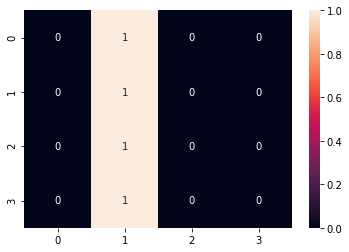

In [24]:
sns.heatmap(cm_vgg, annot=True);

In [ ]:
sns.heatmap(cm_res, annot=True)

# Stacking the models

In [ ]:
new_X_trn = []

for i in tqdm(range(0, 9015)):
    feat = np.concatenate(( (temp_iv3_trn[i] - 9) / 10.0, 
                            (temp_vgg_trn[i] + 1) / 10.0, 
                            (temp_res_trn[i] + 6) / 10.0 ))
    new_X_trn.append(feat)
    
new_X_trn = np.array(new_X_trn)
new_X_trn.shape

In [ ]:
new_X_val = []

for i in tqdm(range(0, 1000)):
    feat = np.concatenate(( (temp_iv3_val[i] - 9) / 10.0, 
                            (temp_vgg_val[i] + 1) / 10.0, 
                            (temp_res_val[i] + 6) / 10.0 ))
    new_X_val.append(feat)
    
new_X_va; = np.array(new_X_val)
new_X_val.shape

In [ ]:
final_model = models.Sequential()

final_model.add(layers.Dense(64, activation='relu'))
final_model.add(layers.Dense(32, activation='relu'))
final_model.add(layers.Dense(16, activation='relu'))
final_model.add(layers.Dense(8, activation='relu'))
final_model.add(layers.Dense(4))

In [ ]:
final_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
final_model.fit(new_X_trn, new_y_trn, 
                epochs=10, callbacks=[earlystop_callback]
                validation_data=(new_X_val, new_y_val))

In [ ]:
predict_y_final_val = []
temp_final_val = final_model.predict(new_X_val)

for i in tqdm(range(0, 1000)):
    pred = np.argmax(temp_final_val[i])
    predict_y_final_val.append(pred)

In [ ]:
cm_final = tf.math.confusion_matrix(np.array(df['risk'])[:-1000], np.array(predict_y_final_val))

cm_final = np.array(cm_final).astype('float32')

cm_final[0] = cm_final[0] / (1.0 * cm_final[0].sum())
cm_final[1] = cm_final[1] / (1.0 * cm_final[1].sum())
cm_final[2] = cm_final[2] / (1.0 * cm_final[2].sum())
cm_final[3] = cm_final[3] / (1.0 * cm_final[3].sum())

In [ ]:
sns.heatmap(cm_final, annot=True)

# New Original Model

In [ ]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [ ]:
df = df.sample(frac = 1).reset_index()

df.head()

In [ ]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(15,30), sharex=True)

sns.histplot(x='localization', data=df[df['risk'] == 0.0], color='green', stat='probability', ax=axs[0]).set_title('risk 0')
sns.histplot(x='localization', data=df[df['risk'] == 1.0], color='yellow', stat='probability', ax=axs[1]).set_title('risk 1')
sns.histplot(x='localization', data=df[df['risk'] == 2.0], color='orange', stat='probability', ax=axs[2]).set_title('risk 2')
sns.histplot(x='localization', data=df[df['risk'] == 3.0], color='red', stat='probability', ax=axs[3]).set_title('risk 3')

In [ ]:
X = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (150,200))
    img = image.img_to_array(img) / 255.0
    
    
    X.append(img)

In [ ]:
X = np.array(X)

X.shape

In [ ]:
risk = []

for ele in df['risk']:
    risk.append(tf.one_hot(int(ele), 4))
    
y = np.array(risk)
y.shape

In [ ]:
ori_model = models.Sequential()
ori_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(150,200,3)))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(32, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(16, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Flatten(name="feature_output"))

ori_model.add(layers.Dense(1024, activation='relu'))
ori_model.add(layers.Dense(256, activation='relu'))
ori_model.add(layers.Dense(64, activation='relu'))
ori_model.add(layers.Dense(4))

In [ ]:
ori_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
ori_model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16)

In [ ]:
ori_model.save('./models/feature')

In [ ]:
loaded_model = tf.keras.models.load_model("./models/feature")


feature_extractor = tf.keras.Model(
    inputs=loaded_model.inputs,
    outputs=loaded_model.get_layer(name="feature_output").output,
)

In [ ]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)

In [ ]:
feature_vector = np.array(feature_vector)

In [ ]:
feature_vector.shape

In [ ]:
image_features = feature_extractor(X)

In [ ]:
X = []
for img_feat, feat in zip(image_features, feature_vector):
    X.append(np.concatenate((img_feat, feat)))

X = np.array(X)

In [ ]:
model = models.Sequential()

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16, sample_weight=sample_weights)

In [ ]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [ ]:
df = df.sample(frac = 1).reset_index()

df.head()

In [ ]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append('no')
    elif df.iloc[i]['dx'] == 'nv':
        risk.append('lo')
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append('md')
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append('hi')
        
df['risk'] = risk

df.head()

In [ ]:
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

df.head()

In [ ]:
# VGG-16
VGG_load = VGG16(weights='imagenet')

model = models.Sequential()
model.add(VGG_load)
model.add(layers.Dense(4))

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    vertical_flip=True, validation_split=0.1, zoom_range=0.3)

In [ ]:
df['risk'].value_counts()

In [ ]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training').class_indices

In [ ]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation').class_indices

In [ ]:
class_weights = {'hi':1, 'lo':0.25, 'md':5, 'no':1}

In [ ]:
sample_weights = []

for i in range(0, 10015):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights

df.head()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

model.fit(
    x=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training'),
    validation_data=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation'),
    epochs=50)

In [ ]:
feature_vector = []

for i in tqdm(range(0, 10015)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)
feature_vector = np.array(feature_vector)

feature_vector.shape

In [ ]:
unique, counts = np.unique(feature_vector, return_counts=True, axis=1)

In [ ]:
unique

In [ ]:
feature_extractor = tf.keras.Model(
    inputs=VGG_load.inputs,
    outputs=VGG_load.layers[-4].output,
)

In [ ]:
preprocessed = []

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    feat_vec = feature_vector[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file, target_size= (224,224))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img_feat = feature_extractor(img)

    preprocessed.append(np.concatenate((img_feat, feat_vec)))
    
preprocessed = np.array(preprocessed)

In [ ]:
ohr = []

for i in range(0, 10015):
    risk = df.iloc[i]['risk']
    
    if risk == 'no':
        ohr.append(tf.one_hot(0, 4))
    elif risk == 'lo':
        ohr.append(tf.one_hot(1, 4))
    elif risk == 'md':
        ohr.append(tf.one_hot(2, 4))
    elif risk == 'hi':
        ohr.append(tf.one_hot(3, 4))
        
ohr = np.array(ohr)

ohr.shape

In [ ]:
ohr

In [ ]:
new_model = models.Sequential()
new_model.add(layers.Dense(4096, activation='relu'))
new_model.add(layers.Dense(2048, activation='relu'))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(4))

In [ ]:
new_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
new_model.fit(preprocessed, ohr, sample_weight=np.array(df['weight']), epochs=10, validation_split=0.1)